In [5]:
from pysad.models import xStream
from pysad.transform.probability_calibration import ConformalProbabilityCalibrator
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from river import anomaly

import numpy as np

import matplotlib.pyplot as plt


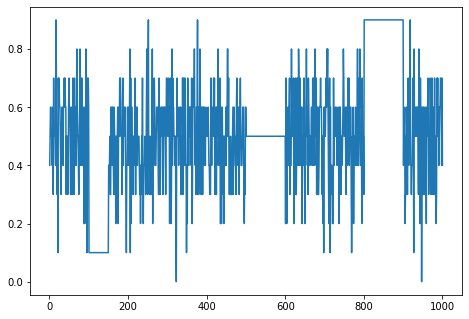

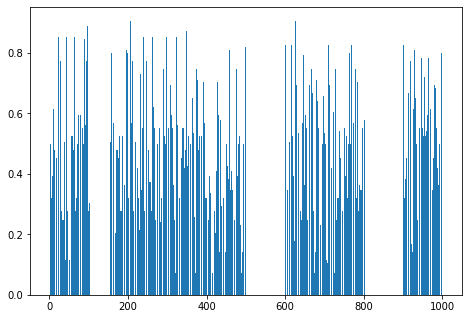

In [6]:
# X = [0.5, 0.45, 0.43, 0.44, 0.445, 0.45, 0.0]
X = np.random.binomial(10,0.5,1000)/10
# Drop values low
for i in range(100,150):
    X[i] = 0.1

# Fix middle values
for i in range(500,600):
    X[i] = 0.5
    
# Drop values high
for i in range(800,900):
    X[i] = 0.9

hst = anomaly.HalfSpaceTrees(
     n_trees=5,
     height=3,
     window_size=3,
     seed=42
 )

for x in X[:3]:
    hst = hst.learn_one({'x': x})  # Warming up

score_list = []
for x in X:
    features = {'x': x}
    hst = hst.learn_one(features)
    score = hst.score_one(features)
    score_list.append(score)
#     print(f'Anomaly score for x={x:.3f}: {score:.3f}')
# print(score_list)

# Dataset
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.arange(1,1001),X)
plt.show()

# Anomaly detection
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(1,1001),score_list)
plt.show()


## PySad

In [10]:
np.random.seed(61)  # Fix seed.

model = xStream()  # Init model.
calibrator = ConformalProbabilityCalibrator(windowed=True, window_size=300)  # Init probability calibrator.
streaming_data = X  # Get streamer.

xstream_count = 0
xstream_score = []
for x in X: # Stream data.
    anomaly_score = model.fit_score_partial(x)  # Fit to an instance x and score it.

    calibrated_score = calibrator.fit_transform(anomaly_score)  # Fit & calibrate score.
    xstream_score.append(calibrated_score)
    # Output if the instance is anomalous.
    if calibrated_score > 0.95:  # If probability of being normal is less than 5%.
        xstream_count += 1
        # print(f"Alert: {i}th data point is anomalous.")
print(f'Anamolies detected: {xstream_count}')

Anamolies detected: 28


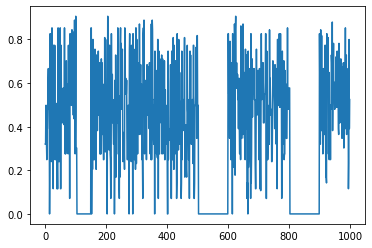

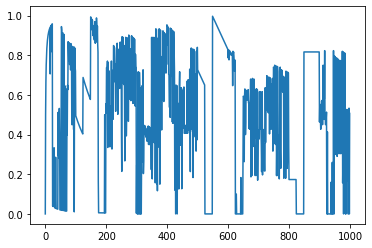

In [12]:
plt.figure()
plt.plot(score_list)
plt.figure()
plt.plot(xstream_score)


In [9]:
model = compose.Pipeline(
    preprocessing.MinMaxScaler(),
    anomaly.HalfSpaceTrees(seed=42)
)

auc = metrics.ROCAUC()

i = 0
fraud_count = 0
true_fraud = 0

for x, y in datasets.CreditCard().take(8000):
    print(x)
    score = model.score_one(x)
    model = model.learn_one(x, y)
    auc = auc.update(y, score)
    if score > 0.85:
        fraud_count = fraud_count + 1
    if y == 1:
        true_fraud = true_fraud + 1
        # print(f'Anomaly score for amount={x["Amount"]} ; y={y}: {score}')
    i = i + 1

print(f'Fraud count: {fraud_count}')
print(auc)

{'Time': 0.0, 'V1': -1.3598071336738, 'V2': -0.0727811733098497, 'V3': 2.53634673796914, 'V4': 1.37815522427443, 'V5': -0.338320769942518, 'V6': 0.462387777762292, 'V7': 0.239598554061257, 'V8': 0.0986979012610507, 'V9': 0.363786969611213, 'V10': 0.0907941719789316, 'V11': -0.551599533260813, 'V12': -0.617800855762348, 'V13': -0.991389847235408, 'V14': -0.311169353699879, 'V15': 1.46817697209427, 'V16': -0.470400525259478, 'V17': 0.207971241929242, 'V18': 0.0257905801985591, 'V19': 0.403992960255733, 'V20': 0.251412098239705, 'V21': -0.018306777944153, 'V22': 0.277837575558899, 'V23': -0.110473910188767, 'V24': 0.0669280749146731, 'V25': 0.128539358273528, 'V26': -0.189114843888824, 'V27': 0.133558376740387, 'V28': -0.0210530534538215, 'Amount': 149.62}
{'Time': 0.0, 'V1': 1.19185711131486, 'V2': 0.26615071205963, 'V3': 0.16648011335321, 'V4': 0.448154078460911, 'V5': 0.0600176492822243, 'V6': -0.0823608088155687, 'V7': -0.0788029833323113, 'V8': 0.0851016549148104, 'V9': -0.2554251281